# Molecular Isotopic Distributions Part 2: Combinations

#TODO
- Link to some sites and software that calculate molecular isotope distributions (here or in part 1?)
- Document functions with type hints and docstrings

This blog post presents a more computationally efficient way to determine the abundance of the molecular isotopes of a molecule.

In [part 1](***), we created a molecule for each possible placement of each isotope in a molecule. While that worked, it was computationally expensive because it required creating each permutation. In this blog post, we'll create each combination only once and calculate its abundance using the binomial distribution. While calculating the molecular isotopes of naphthalene took about 170 seconds using the permutations method, it takes 0.1 seconds using the combinations method below.

In [1023]:
%%capture
%!pip install rdkit
%!pip install mendeleev

In [1024]:
from collections import defaultdict
import math
import copy

from IPython.display import display, Markdown
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

import mendeleev
# from mendeleev import element
from rdkit import Chem
from rdkit.Chem import Descriptors

We'll use the same molecule so we can compare results to the previous blog post. We also copy in code from the previous post.

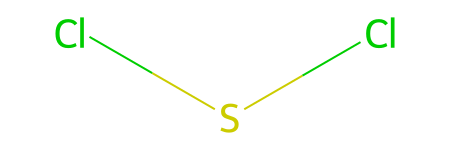

In [1025]:
sml = "ClSCl"
# sml = "[S]"
# sml = "[S][S][S]"
# sml = "c1c2ccccc2ccc1"
mol = Chem.AddHs(Chem.MolFromSmiles(sml))
mol

In [1026]:
class MolecularIsotope():
  """Store a molecule's isotopic properties."""
  def __init__(
      self,
      sml: str,
      mol: Chem.rdchem.Mol = None,
      abundance: float = None):
    self.sml = sml
    self.abundance = abundance
    if mol is not None:
      self.mol = mol
    else:
      try:
        self.mol = Chem.MolFromSmiles(sml)
      except:
        self.mol = Chem.MolFromSmiles(sml, sanitize=False)
  def update(self):
    self.mass = Descriptors.ExactMolWt(self.mol)
    self.canon_sml = Chem.MolToSmiles(self.mol)
  def get_mass(self):
    return self.mass

In [1027]:
def composition(
        molecule: Chem.Mol,
        isotopes=False):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, ethanol (SMILES [13C](H)(H)(H)CO, formula C2H6O) returns:
      if isotopes = False (default): {'C': 2, 'O': 1, 'H': 6}.
      if isotopes = True: {'C': {13: 1, 0: 1}, 'O': {0: 1}, 'H': {0: 6}}.

    :param molecule: The RDKit molecule to analyze
    :returns: if isotopes = False (default): a dictionary of element:count entries;
              if isotopes = True: a nested dictionary of element:isotope:count entries.
    """
    # Check that there is a valid molecule
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        molecule = Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule.GetAtoms():
            element_symbol = atom.GetSymbol()
            # If isotopes not requested, simply count the number of atoms of each element
            if not isotopes:
                comp[element_symbol] += 1
            # If isotopes requested, count the number of each isotope of each element
            else:
                isotope = atom.GetIsotope()
                try:
                    comp[element_symbol][isotope] += 1
                except:
                    comp[element_symbol] = defaultdict(lambda: 0)
                    comp[element_symbol][isotope] += 1
        return comp

In [1028]:
def flatten_ndarray(arr):
    flat_list = []
    for element in arr:
        if isinstance(element, np.ndarray):
            flat_list.extend(flatten_ndarray(element))
        else:
            flat_list.append(element)
    return flat_list

## Calculating distributions

Here's a function to calculate the binomial distribution

#TODO give formula in LaTeX

#TODO Show how to calculate the number of combinations

In [1029]:
def binomial_coefficient(n, k):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

In [1030]:
binomial_coefficient(2,1)

2

In [1031]:
binomial_coefficient(3,3)

1

We also need to list each distribution of n items in k bins. Here, n is the number of atoms of a given element, and k is the count of a given isotope that will occur in that molecule.

- For an element with only one isotope, all atoms of that element will have that isotope, so there is only one way to distribute the isotopes amongst the atoms. For example, if we have four atoms of element X, and X has only one isotope, n = 4 and k = 4.
- For an element with two isotopes, any atoms of that element that are not populated by the first isotope must be populated by the second isotope. For example, if our molecule has four carbon atoms, and we assign C-12 to one atom, there are three atoms remaining, and they must all be assigned C-13. Thus the number of combinations is
    - C-12: n = 4, k = 1; 4 choose 1 = 4
    - C-13: n = 3, k = 3; 3 choose 3 = 1
    so the number of combinations of the second isotope is always 1. We multiply the combinations of each isotope, so there are a total of 4 * 1 = 4 combinations.
- For an element with more than two isotopes, things get more complicated. Consider O3 (ozone) with isotopes O-16, O-17, and O-18. To calculate the number of combinations that will produce 16O17O18O:
    - O-16: n = 3, k = 1; 3 choose 1 = 3
    - O-17: n = 2, k = 1; 2 choose 1 = 2
    - O-18: n = 1, k = 1; 1 choose 1 = 1
    Multiplying the combinations gives 3 * 2 * 1 = 6.

In [1034]:
def distribute_items(n, k):
    def backtrack(remaining_items, bins, current_bin):
        if current_bin == k:
            if remaining_items == 0:
                results.append(list(bins))
            return

        for items_in_current_bin in range(remaining_items + 1):
            bins[current_bin] = items_in_current_bin
            backtrack(remaining_items - items_in_current_bin, bins, current_bin + 1)

    results = []
    bins = [0] * k
    backtrack(n, bins, 0)
    return results

For example, for our four (n) chlorine atoms, we have two (k) isotopes, 35 and 37. We can thus have
- zero atoms of isotope 35 and four of 37
- one atom of isotope 35 and three of 37
- two atoms of each isotope
- three atoms of isotope 35 and one of 37
- four atoms of isotope 35 and zero of 37

as given by:

In [1035]:
def atom_set(molecule: Chem.Mol) -> set[str]:
    """Get the set of atoms in an RDKit molecule

    :param molecule: The molecule to analyze
    :rtype: A set of atomic symbols.
    """
    # Check that there is a valid molecule
    if molecule:
      # Add hydrogen atoms--RDKit excludes them by default
      molecule_with_Hs = Chem.AddHs(molecule)
      atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
      return atom_symbols

We define a function to recursively traverse a NumPy array containing objects and extract a given property into an array of the same shape as the original.

In [1036]:
def extract_properties(arr, prop_name):
    if isinstance(arr, np.ndarray):
        # If arr is a NumPy ndarray, iterate through its elements and apply the function recursively
        return np.array([extract_properties(item, prop_name) for item in arr])
    elif isinstance(arr, list):
        # If arr is a list, iterate through its elements and apply the function recursively
        return [extract_properties(item, prop_name) for item in arr]
    elif hasattr(arr, prop_name):
        # If arr has the specified property, extract its value
        return getattr(arr, prop_name)
    else:
        # If the property is not found, return None
        return None

The following function sets the isotope for each atom of a given element and calculates the abundance based on that element by raising the abundance of an isotope to the power of the count of that isotope in the molecule. When the next element is considered, the code will make independent copies of the molecule that was isotopically labeled for the previous element, then apply isotopic labels for the next element. As a result, the isotopic labeling and abundance calculations are done only once for each element, lessening the computations required.

In [1037]:
def assign_isotopes(
      arr, 
      isotope_count_distribution, 
      prefix,
      this_element,
      n_this_element,
      ):
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            new_prefix = prefix + [i]
            assign_isotopes(
               arr = arr[i], 
               isotope_count_distribution = isotope_count_distribution, 
               prefix = new_prefix, 
               this_element = this_element,
               n_this_element = n_this_element,
               )
    else:
        # Clone the distribution, making it independent so the next loop won't be affected
        distribution = copy.deepcopy(isotope_count_distribution[prefix[0]])

        # Calculate abundances
        if arr.abundance is None:
           arr.abundance = 1

        # Set a and b to the multiplicative identity, 1
        a = 1
        b = 1

        # Keep track of how many atoms have yet to be assigned (n)
        n_remaining = n_this_element

        # Iterate through the isotopes
        for isotope_index, isotope_count in enumerate(distribution):
          # Get the abundance of this isotope
          a_this_isotope = isotopes[this_element][isotope_index][1]
          # Multiply the molecule's abundance by the abundance of this isotope to the power of its count
          a *= a_this_isotope**isotope_count

          # k is the count of this isotope
          b_this_isotope = binomial_coefficient(n_remaining, isotope_count)
          b *= b_this_isotope

          # Decrease n, the number of atoms yet to be assigned, by the count of this isotope
          n_remaining -= isotope_count
        arr.abundance *= a*b

        # Assign isotopes to atoms of this element type
        for atom in arr.mol.GetAtoms():
          if atom.GetSymbol() == this_element:
            # Count down for each isotope, going on to the next when zero
            for isotope_index, isotope in enumerate(distribution):
              if distribution[isotope_index] > 0:
                  atom.SetIsotope(isotopes[this_element][isotope_index][0])
                  distribution[isotope_index] -= 1
                  # If assign isotope to this atom, move on to next atom
                  break

        isotopes_list = []
        for atom in arr.mol.GetAtoms():
          isotopes_list.append(atom.GetIsotope())

        # Update the properties of the MolecularIsotope to get exact masses
        arr.update()
    return arr

## Set up

We start by creating a data structure with each element in the molecule, and a nested list of mass number and abundance for each isotope.

In [1038]:
set_of_atoms = atom_set(mol)
print(set_of_atoms)
isotopes = {}
for atom in set_of_atoms:
  element_isotopes = mendeleev.element(atom).isotopes
  occuring_isotopes = [[isotope.mass_number, isotope.abundance/100] for isotope in element_isotopes if isotope.abundance != None]
  isotopes[atom] = occuring_isotopes
print(isotopes)

{'Cl', 'S'}


{'Cl': [[35, 0.758], [37, 0.242]], 'S': [[32, 0.9484999999999999], [33, 0.0076300000000000005], [34, 0.04365], [36, 0.00015800000000000002]]}


## Scale of the problem

In [1032]:
def combos_with_repetition(n, r):
    return int((math.factorial(r + n - 1)) / (math.factorial(r) * math.factorial(n-1)))

In [1033]:
combos_with_repetition(2,2)

3

In [1065]:
for n_atoms, n_isotopes in [(2,2), (6,2), (12,2), (18,2), (60,2), (100,2), (1000,2), (100000,2), (100,4), (10000,4), (100000,4)]:
    c = combos_with_repetition(n_atoms, n_isotopes)
    p = permutations_with_repetition(n_atoms, n_isotopes)
    print(c, p, p/c)

3 4 1.3333333333333333
21 36 1.7142857142857142
78 144 1.8461538461538463
171 324 1.894736842105263
1830 3600 1.9672131147540983
5050 10000 1.9801980198019802
500500 1000000 1.998001998001998
5000050000 10000000000 1.999980000199998
4421275 100000000 22.617909992027187
416916712502500 10000000000000000 23.98560599784072
4166916671250024960 100000000000000000000 23.99856005999784


For each element, we have n atoms (of that element in the molecule) and r isotopes. The formula for the number of combinations with repetition allowed is ^. For a molecule with multiple elements, we take the product of the number of combinations for each element in that molecule. For example, for SCl2:
- S: n = 1, r = 4, C = 4
- Cl: n = 2, r = 2, C = 3
So C for the molecule is 4*3 = 12.

--Move to previous post?
For permutations, we choose from amongst n isotopes r times where r is the number of atoms of that element in the molecule. For SCl2:
- S: n = 4, r = 1, P = 4^1 = 4
- Cl: n = 2, r = 2, P = 2^2 = 4
So P for the molecule is 4*4 = 16.

## Setting the isotope of each atom in each combination

To be more computationally efficient, we will create only one instance of each isotopologue, then calculate its abundance.


In [1039]:
# Initialize ndarray to hold MolecularIsotope objects
molecular_isotopes:np.ndarray = np.array(MolecularIsotope)

# Loop through the elements in this molecule
for this_element, n_this_element in composition(mol).items():
  n_isotopes_this_element = len(isotopes[this_element])

  # Calculate possible distributions of isotopes across atoms of this element
  isotope_count_distribution = distribute_items(n_this_element, n_isotopes_this_element)
  n_distributions = len(isotope_count_distribution)

  if molecular_isotopes.shape == ():
     # Start by creating a 1-dimensional array,
     # making sure to make each mol an independent object
     molecular_isotopes = np.array([MolecularIsotope(sml=sml, mol=Chem.Mol(mol)) for _ in range(n_distributions)], dtype=object)
  else:
    # Create a list of m copies of the current object, 
    # namely the n-1 dimensional ndarray representing elements prior to this element
    molecular_isotopes_list = [copy.deepcopy(molecular_isotopes) for _ in range(n_distributions)]
    
    # Convert the list of copies to a NumPy ndarray
    molecular_isotopes = np.array(molecular_isotopes_list, dtype=object)
    
  # Assign isotopes and abundances
  molecular_isotopes = assign_isotopes(
     arr=molecular_isotopes,
     isotope_count_distribution=isotope_count_distribution, 
     prefix=[],
     this_element=this_element,
     n_this_element=n_this_element,
     )

To sort the isotopologues by mass, we flatten the array into one dimension.

In [1040]:
molecular_isotopes_flat = flatten_ndarray(molecular_isotopes)

# Create a list of the masses
masses_array_flat = list(extract_properties(molecular_isotopes_flat, "mass"))

# Create a list of the order of each item by mass, for example the smallest mass will have a value of zero 
order = np.argsort(masses_array_flat).tolist()

# Sort the molecular isotopes by that ordering list
sorted_molecular_isotopes = sorted(molecular_isotopes_flat, key=lambda x: order.index(molecular_isotopes_flat.index(x)))

In [1041]:
def mol_to_formatted_formula(
    mol: Chem.Mol,
    isotopes: bool = False,
) -> dict[str, str]:
    if mol is None:
        return "Invalid molecule"
    comp = composition(mol, isotopes)

    formula = {"markdown": "", "latex": ""}

    if isotopes:
        isotopes_dict = defaultdict(lambda: defaultdict(str))
        subscripts = defaultdict(lambda: defaultdict(int))
        superscripts = defaultdict(list)

        for element, counts in comp.items():
            for isotope, count in counts.items():
                if count > 1:
                    subscripts[element][isotope] = count
                if isotope != 0:
                    superscripts[element].append(isotope)

                isotopes_dict[element][isotope] = 1
            # Sort the element's isotopes from lowest to highest
            superscripts[element].sort()

        last_item_is_subscript = False
        sorted_element_keys = sorted(isotopes_dict.keys())
        for element in sorted_element_keys:
            isotope_count_pairs = isotopes_dict[element]
            # Sort the element's isotopes from lowest to highest
            sorted_isotope_keys = sorted(isotope_count_pairs.keys())
            for isotope in sorted_isotope_keys:
                if element in superscripts:
                    if isotope in superscripts[element]:
                        formula["markdown"] += f"<sup>{isotope}</sup>"

                        # If superscript immediately follows subscript,
                        # add a small amount of horizontal space using an empty group {}
                        # to prevent them from vertically overlapping
                        if last_item_is_subscript:
                            formula["latex"] += "{}"
                        formula["latex"] += "^{ %d}" % isotope
                        last_item_is_subscript = False
                formula["markdown"] += element
                formula["latex"] += element
                last_item_is_subscript = False
                if element in subscripts:
                    if isotope in subscripts[element]:
                        isotope_count = subscripts[element][isotope]
                        formula["markdown"] += f"<sub>{isotope_count}</sub>"
                        formula["latex"] += "_{ %d}" % isotope_count
                    last_item_is_subscript = True
        # Add beginning and ending dollar signs to LaTeX formula
        formula["latex"] = "$" + formula["latex"] + "$"
    else:
        # Handling the case when isotopes is False
        sorted_element_keys = sorted(comp.keys())

        for element in sorted_element_keys:
            count = comp[element]
            formula["markdown"] += element
            formula["latex"] += element
            if count > 1:
                formula["markdown"] += f"<sub>{count}</sub>"
                formula["latex"] += "_{ %d}" % count
        formula["latex"] = "$" + formula["latex"] + "$"

    return formula

In [1042]:
def dict_list_to_markdown_table(data, number_rows=False):
    """
    Convert a list of dictionaries into a Markdown table.

    Args:
        data (list): A list of dictionaries, where each dictionary corresponds to a row in the table.
        include_row_numbers (bool): Whether to include a row number column.

    Returns:
        str: The Markdown-formatted table as a string.
    """
    if not data:
        return ""

    # Extract column headers from the keys of the first dictionary
    headers = data[0].keys()

    # If include_row_numbers is True, add the "Row #" column
    if number_rows:
        headers = ["#"] + list(headers)

    # Create the table headers
    table = "| " + " | ".join(headers) + " |\n"

    # Create the title divider line
    table += "|"
    for _ in headers:
        table += " --- |"
    table += "\n"

    # Create the table body
    for i, row in enumerate(data):
        if number_rows:
            row_data = [i + 1] + [row.get(header, "") for header in headers[1:]]
        else:
            row_data = [row.get(header, "") for header in headers]

        table += "| " + " | ".join(map(str, row_data)) + " |\n"

    return table

In [1043]:
data_dict_list = []
for mol_isotope in sorted_molecular_isotopes:
    mol_isotope.update()
    data_dict = {prop: getattr(mol_isotope, prop) for prop in vars(mol_isotope).keys()}
    data_dict["mol_isotope"] = mol_isotope
    data_dict_list.append(data_dict)
df = pl.DataFrame(data_dict_list).select(["mass", "abundance", "mol"])
df = df.with_columns(
    pl.col("mol").map_elements(lambda x: mol_to_formatted_formula(x, isotopes=True)["markdown"]).alias("formula"),
    pl.col("mol").map_elements(lambda x: mol_to_formatted_formula(x, isotopes=True)["latex"]).alias("formula_latex"),
)

# Choose rows to display in Markdown table
df_display = df.select(["formula", "mass", "abundance"])
table = dict_list_to_markdown_table(
    df_display.rows(named=True),
    number_rows=True)
Markdown(table)

Markdown(
    dict_list_to_markdown_table(
        df_display.rows(named=True),
        number_rows=True,
        )
    )

| # | formula | mass | abundance |
| --- | --- | --- | --- |
| 1 | <sup>35</sup>Cl<sub>2</sub><sup>32</sup>S | 101.90977636 | 0.5449739539999999 |
| 2 | <sup>35</sup>Cl<sub>2</sub><sup>33</sup>S | 102.90916411999999 | 0.00438392332 |
| 3 | <sup>35</sup>Cl<sub>2</sub><sup>34</sup>S | 103.90557225999999 | 0.0250797186 |
| 4 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>32</sup>S | 103.90682627 | 0.34797809199999996 |
| 5 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>33</sup>S | 104.90621402999999 | 0.00279923336 |
| 6 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>34</sup>S | 105.90262216999999 | 0.0160139628 |
| 7 | <sup>37</sup>Cl<sub>2</sub><sup>32</sup>S | 105.90387618 | 0.05554795399999999 |
| 8 | <sup>35</sup>Cl<sub>2</sub><sup>36</sup>S | 105.90478612 | 9.078111200000001e-05 |
| 9 | <sup>37</sup>Cl<sub>2</sub><sup>33</sup>S | 106.90326394 | 0.00044684332 |
| 10 | <sup>37</sup>Cl<sub>2</sub><sup>34</sup>S | 107.89967208 | 0.0025563186 |
| 11 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>36</sup>S | 107.90183603 | 5.7965776e-05 |
| 12 | <sup>37</sup>Cl<sub>2</sub><sup>36</sup>S | 109.89888594 | 9.253112e-06 |


### Checking our abundances

To verify that we calculated and aggregated abundances correctly, we check that the sum of abundances of the isotopomers is 1. (It might be very slightly different depending on the isotope data, numerical precision of operations, etc.)

In [1044]:
mol_isotopes_abundances = df["abundance"].to_list()
abundance_sum = sum(mol_isotopes_abundances)
print(abundance_sum)

0.999938


## Plot abundance vs. mass results

For the graph, to prevent a forest of short lines and colliding labels due to the be many isotopomers with very low abundance, we might want to limit the plot to a cutoff level of abundance.

In [1045]:
cutoff = 0.05
df_cutoff = df.filter(pl.col("abundance") > cutoff)

# Format as Markdown table
df_display_cutoff = df_cutoff.select(["formula", "mass", "abundance"])
table_cutoff = dict_list_to_markdown_table(
    df_display_cutoff.rows(named=True),
    number_rows=True)
Markdown(table_cutoff)

| # | formula | mass | abundance |
| --- | --- | --- | --- |
| 1 | <sup>35</sup>Cl<sub>2</sub><sup>32</sup>S | 101.90977636 | 0.5449739539999999 |
| 2 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>32</sup>S | 103.90682627 | 0.34797809199999996 |
| 3 | <sup>37</sup>Cl<sub>2</sub><sup>32</sup>S | 105.90387618 | 0.05554795399999999 |


These results agree with the analogous table in the previous blog post. Now we can plot the isotopomers above that cutoff level of abundance.

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


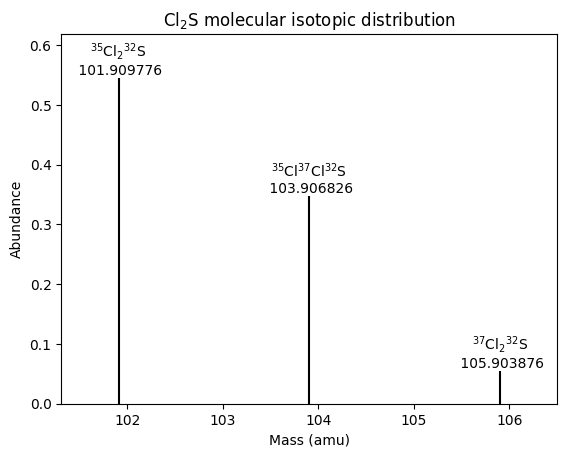

In [1046]:
# Create the scatter plot using Seaborn; don't use markers because we'll plot lines instead
sns.scatterplot(x='mass', y='abundance', data=df_cutoff, marker='')

plt.xlabel('Mass (amu)')
plt.ylabel('Abundance')

# Generate molecular formula of molecule
formula = mol_to_formatted_formula(mol)["latex"].strip("$")

# Use C-style string formatting with the % operator to avoid conflicts with using braces for both LaTeX and {}.format()
title = r"${\rm %s}$ molecular isotopic distribution" % formula
plt.title(title)

# Adjust x-axis limits to allow more space on the left and right for labels
xrange = max(df_cutoff['mass']) - min(df_cutoff['mass'])
xpad = xrange * 0.15
plt.xlim(min(df_cutoff['mass']) - xpad, max(df_cutoff['mass']) + xpad)

# Adjust y-axis limits to start at zero and allow more space on the top for labels
yrange = max(df_cutoff['abundance']) - min(df_cutoff['abundance'])
ypad = yrange * 0.15
plt.ylim(0, max(df_cutoff['abundance']) + ypad)

# Iterate through the rows (data points)
for index, (mass, abundance, formula) in enumerate(zip(df_cutoff['mass'], df_cutoff['abundance'], df_cutoff['formula_latex'])):
    # Add vertical lines from each data point to the x-axis
    plt.vlines(x=mass, ymin=0, ymax=abundance, colors='black')

    # Label the data points by mass
    label = r"${\rm %s}$ %s %s" % (formula.strip("$"), "\n", round(mass, 6))
    plt.text(
        x=mass, 
        y=abundance, 
        s=label, 
        ha='center',
        va='bottom')

plt.show()

## Conclusion

Using the binomial distribution to calculate the number of occurrences for each isotopic molecular formula is much more efficient than creating a separate molecule for each position of each isotope. Because all we care about is the molecular mass, it is not important where in the molecule each isotope is, just how many of each isotope there are. Combinations, which ignore the order of isotopic atoms, thus suffice and save computation compared to using permutations, which consider the order of isotopic atoms.